In [1]:
import pdb, os, pickle,json 
import math 
import random
import pandas as pd
import numpy as np 
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp 
from matplotlib import pyplot as plt 
import seaborn as snum_seeds 
from sklearn.metrics import adjusted_rand_score 
import requests
# humanUtils
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/humanUtils.py")
with open('humanUtils.py', 'w') as f:
    f.write(r.text)
from humanUtils import * 
# analysis
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/analysis.py")
with open('analysis.py', 'w') as f:
    f.write(r.text)
from analysis import *
# utils 
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/utils.py")
with open('utils.py', 'w') as f:
    f.write(r.text)
from utils import * 
%load_ext autoreload
%autoreload 2
snum_seeds.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22
condL = ['blocked','interleaved','early','middle','late']



Here are the parameters for you to toggle

In [2]:
sim_name = "my_sim"
schema_inference_off = True
concentration = 1.6
stickiness = 1.8
sparsity = 0.2
num_seeds = 50

Here is where you can try out varying different parameters across model seeds. For each paramater X, to vary that parameter across seeds you must do (1) mark the add_parameterX_variance_across_seeds flag to True and (2) pick your desire standard deviation, lower bound and upper bound for the truncated normal distribution which we sample from to get the parameter value for each seed. This information in the form of the dictionary parameterX_info will be passed to the simulation driver. You are able to vary one, all three, or some combination of these three parameters at the same time and see the results. If you set the add_X_variance_across_seeds to False, the X_info dictionary will become None which is how the simulation driver will know to keep that parameter constant across seeds. 

In [3]:
# concentration
add_concentration_variance_across_seeds = False
if add_concentration_variance_across_seeds:
    concentration_sd = 0.3
    concentration_lb = 0
    concentration_ub = np.inf
    concentration_mean = concentration
    concentration_info = {
        'concentration_mean': concentration_mean,
        'concentration_sd': concentration_sd,
        'concentration_lb': concentration_lb,
        'concentration_ub': concentration_ub
    }
else:
    concentration_info = None # this indicates constant concentration across seeds

# stickiness
add_stickiness_variance_across_seeds = False
if add_stickiness_variance_across_seeds:
    stickiness_sd = 0.3
    stickiness_lb = 0
    stickiness_ub = 100
    stickiness_mean = stickiness
    stickiness_info = {'stickiness_mean':stickiness_mean,
                        'stickiness_sd': stickiness_sd,
                        'stickiness_lb': stickiness_lb,
                        'stickiness_ub': stickiness_ub
                        }
else:
    stickiness_info = None # this indicates constant stickiness across seeds

# sparsity
add_sparsity_variance_across_seeds = False
if add_sparsity_variance_across_seeds:
    sparsity_sd = 0.05
    sparsity_lb = 0
    sparsity_ub = np.inf
    sparsity_mean = sparsity
    sparsity_info = {'sparsity_mean':sparsity_mean,
                        'sparsity_sd': sparsity_sd,
                        'sparsity_lb': sparsity_lb,
                        'sparsity_ub': sparsity_ub
                        }
else:
    sparsity_info = None # this indicates constant sparsity across seeds


Run the model here and save the data

In [4]:
model_acc_df_list = []
model_states_df_list = []
args = {'sem': {'skipt1': schema_inference_off, 'ppd_allsch': 0}, 'sch': {'concentration': concentration, 'stickiness': stickiness, 'sparsity': sparsity}, 'exp': {'condition': None, 'n_train': 160, 'n_test': 40}}
exp_batch_data, concentrationValue_each_seed,stickinessValue_each_seed,sparsityValue_each_seed  = run_batch_exp_curr(num_seeds,
                                                                                                                     args,
                                                                                                                     condL,
                                                                                                                     concentration_info= concentration_info,
                                                                                                                     stickiness_info= stickiness_info,
                                                                                                                     sparsity_info=sparsity_info)
# unpack and save
exp = np.stack([exp_batch_data[c][s]['exp'] for c in range(5) for s in range(num_seeds)]).reshape(5,num_seeds,200,5)
zt = np.stack([exp_batch_data[c][s]['zt'] for c in range(5) for s in range(num_seeds)]).reshape(5,num_seeds,200,5)
xth = np.stack([exp_batch_data[c][s]['xth'].argmax(-1) for c in range(5) for s in range(num_seeds)]).reshape(5,num_seeds,200,5)
acc = unpack_acc(exp_batch_data,mean_over_tsteps=True)
# for each of the condition types (blocked, interleaved, early, middle, late)
for cix in range(5):
    # for each seed
    for six in range(num_seeds):
      # and trial number
      for trix in range(200):
        # just mark it -1000 (this avoids pandas issues later on)
        a = -1000
        model_acc_df_list.append({
          'gs':sim_name,
          'concentration': concentrationValue_each_seed[cix][six], # varied parameter
          'cond':cix, # condition
          'seed':six, # seed
          'trial':trix, # trial
          'acc':acc[cix,six,trix] # get accuracy for this conditon, seed, trial
                                # unpack_acc function averages over tstep in trial
        })
        for tstep in range(5):
          model_states_df_list.append({
          'gs':sim_name,
          'concentration':concentrationValue_each_seed[cix][six],
          'cond':cix,
          'seed':six,
          'trial':trix,
          'tstep':tstep,
          'exp':exp[cix,six,trix,tstep],
          'zt':zt[cix,six,trix,tstep],
          'xth':xth[cix,six,trix,tstep]
          })
model_acc_df = pd.DataFrame(model_acc_df_list)
model_states_df = pd.DataFrame(model_states_df_list)
# make a test column
model_acc_df.loc[:,'test'] = model_acc_df.trial >= 160
model_acc_df.loc[:,'cond_int'] = model_acc_df.cond
model_states_df.loc[:,'cond_int'] = model_states_df.cond
model_acc_df.cond = model_acc_df.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])

TypeError: __init__() got an unexpected keyword argument 'stickiness_wi'

Plot results from the above run of your custom simulation. 

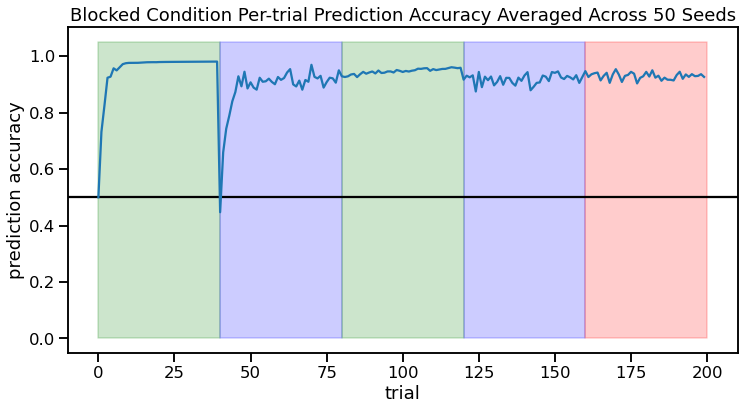

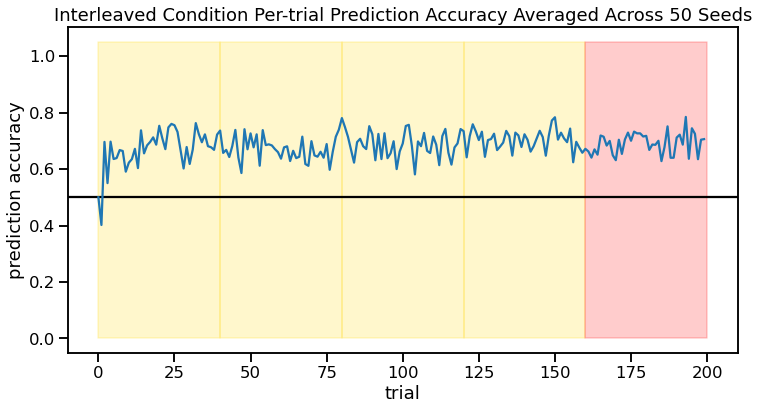

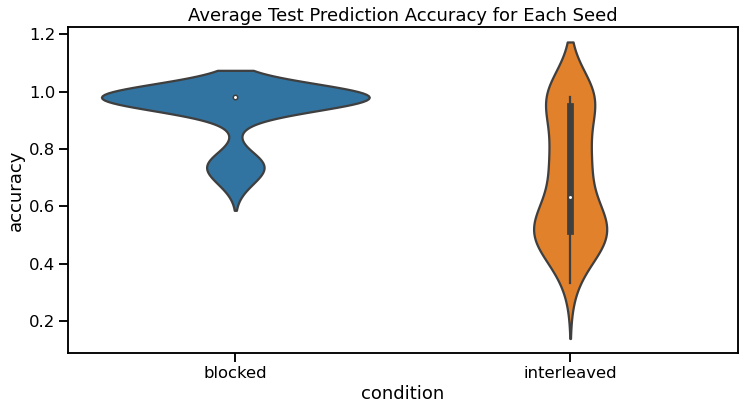

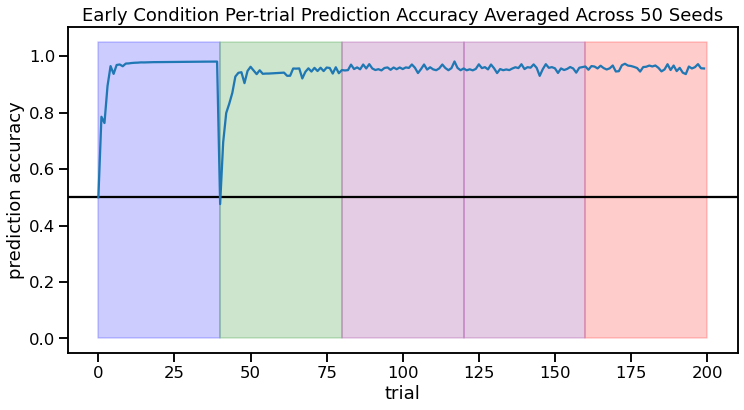

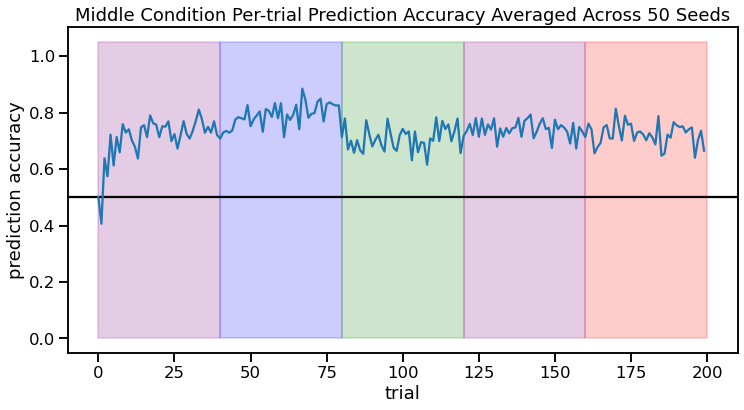

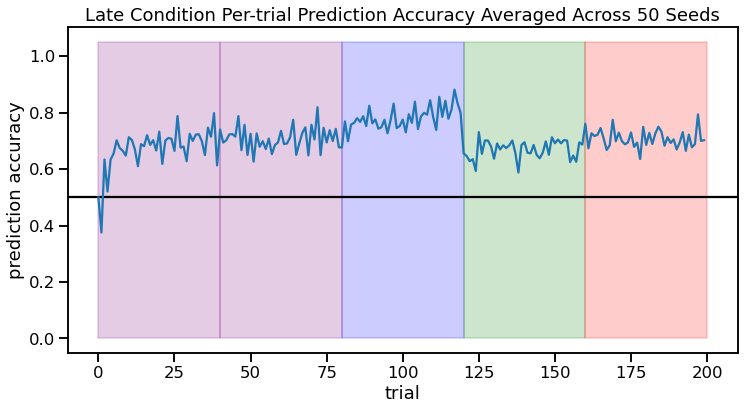

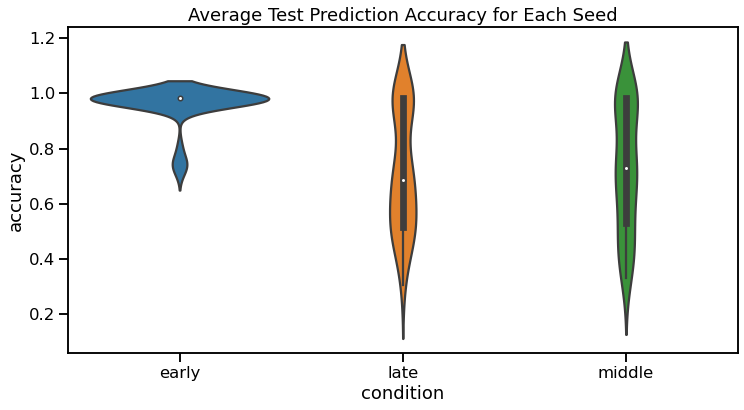

In [ ]:
cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','purple','purple','red'],
  'early': ['blue','green','purple','purple','red'],
  'inserted_early_rep': ['blue','green','purple','purple','red'],
  'inserted_middle': ['purple','blue','green','purple','red'],
  'middle': ['purple','blue','green','purple','red'],
  'inserted_middle_rep': ['purple','blue','green','purple','red'],
  'inserted_late': ['purple','purple','blue','green','red'],
  'late': ['purple','purple','blue','green','red'],
  'inserted_late_rep': ['purple','purple','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False
condL = ['blocked','interleaved','early','middle','late']
condL_upper = ['Blocked','Interleaved','Early','Middle','Late']

def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplot_model(sim_name,condstr,cond_index,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{sim_name}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
  ax.set_ylabel('prediction accuracy')  
  ax.legend().remove()
  ax.set_title(condL_upper[cond_index] + " Condition Per-trial Prediction Accuracy Averaged Across " + str(num_seeds)  +  " Seeds")
  return ax
  
def lineplot_modelBI(sim_name,ax=None):
  for ix in [0,1]:
    ax=lineplot_model(sim_name,condstr=f'cond_int=={ix}' , cond_index = ix,ax=None)
    color_background(ax,['blocked','interleaved'][ix])

def lineplot_modelEML(sim_name):
  for ix in [2,3,4]:
    ax=lineplot_model(sim_name,condstr=f'cond_int=={ix}', cond_index = ix, ax=None)
    color_background(ax,['early','middle','late'][ix-2])

def beeswarm_model(sim_name,condstr, ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{sim_name}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  ax.set_ylabel('accuracy')
  ax.set_xlabel('condition')
  ax.set_title('Average Test Prediction Accuracy for Each Seed')

def beeswarm_modelBI(sim_name):
  beeswarm_model(sim_name,condstr='cond_int<2')

def beeswarm_modelEML(sim_name):
  beeswarm_model(sim_name,condstr='cond_int>=2')


lineplot_modelBI(sim_name)
beeswarm_modelBI(sim_name)
lineplot_modelEML(sim_name)
beeswarm_modelEML(sim_name)